In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import sqlite3
from iminuit import Minuit
from scipy.stats import chi2
#https://math.stackexchange.com/questions/1521128/given-a-line-and-a-point-in-3d-how-to-find-the-closest-point-on-the-line

matplotlib.rc('xtick', labelsize=18)
matplotlib.rc('ytick', labelsize=18)
matplotlib.rc('axes',  labelsize=20)
matplotlib.rc('font', **{'size'   : 18, 'family':'monospace'})
matplotlib.rcParams['figure.figsize'] = (12, 5)
matplotlib.rcParams['figure.titlesize'] = 22

all_dom_coordinates = pd.read_csv('/groups/icecube/debes/work/analyses/Efficiency/data/5083_DOM_coordinates_with_homemade_dom_id_from_burnsample.csv')
folder = '/groups/icecube/debes/work/analyses/Efficiency/data/burnsample_efficiency_reco/'

In [30]:
def divide0(y1,y2):
#    return np.divide(x.astype(np.float32),   y.astype(np.float32),  out=np.zeros_like(y).astype(np.float32), where=y!=0)
    return np.divide(y1, y2, out=np.zeros_like(y2), where=y2!=0)

def divide0err(y1,y2, sigma_y1=None, sigma_y2=None):
    value = np.divide(y1, y2, where=y2!=0)

    if sigma_y1 is None:
        sigma_y1 = np.sqrt(y1)
        print(sigma_y1)
    if sigma_y2 is None:
        sigma_y2 = np.sqrt(y2)
        print(sigma_y2)
    error = value * np.sqrt((sigma_y1/np.abs(y1))**2 + (sigma_y2/np.abs(y2))**2)

    return value, error

In [3]:
nbins = 50
RANGE = (1,3.2)
variable = 'photon_zenith'
use_horizontal_photons = False
n_files = 20

rd_all_doms_counts , rd_activated_counts ,  qrd_activated_counts  = np.zeros((n_files,nbins)), np.zeros((n_files,nbins)), np.zeros((n_files,nbins))
mc_all_doms_counts , mc_activated_counts ,  qmc_activated_counts  = np.zeros((n_files,nbins)), np.zeros((n_files,nbins)), np.zeros((n_files,nbins))
mct_all_doms_counts, mct_activated_counts,  qmct_activated_counts = np.zeros((n_files,nbins)), np.zeros((n_files,nbins)), np.zeros((n_files,nbins))


usecols1 = ['photon_zenith', 'charge', 'photon_distance','activated']
usecols2 = ['photon_zenith', 'charge', 'photon_distance','activated', 'GB_weights']

for i in range(n_files):
    rd_path  = folder+'4k_rd_photon_efficiency_reco_'+str(i)+'.parquet'
    mc_path  = folder+'4k_mc_photon_efficiency_reco_'+str(i)+'.parquet'
    mct_path = folder+'4k_mc_truth_photon_efficiency_reco_'+str(i)+'.parquet'
    rd =  pd.read_parquet(rd_path, columns=usecols1) 
    mc =  pd.read_parquet(mc_path, columns=usecols2)
    mct = pd.read_parquet(mct_path, columns=usecols2)

    mc['GB_weights'] = mc['GB_weights'].apply(lambda x: min(x, 40))
    mct['GB_weights'] = mct['GB_weights'].apply(lambda x: min(x, 40))

    # Choose photons closer than 100m
    rd = rd[rd['photon_distance']<100]
    mc = mc[mc['photon_distance']<100]
    mct = mct[mct['photon_distance']<100]

    # Choose horizontal photons
    if use_horizontal_photons:
        rd  =  rd[np.abs(rd['dom_z'] - rd['cherenkov_z'])<10]
        mc  =  mc[np.abs(mc['dom_z'] - mc['cherenkov_z'])<10]
        mct = mct[np.abs(mct['dom_z']- mct['cherenkov_z'])<10]
    
    ###### Photon distance histograms ######
    hs = {'bins':nbins, 'range':RANGE}
    
    ###### Photon distance histograms ######
    qrdcount, _        = np.histogram(rd[rd['activated'] == 1][variable], **hs,   weights=rd[rd['activated'] == 1]['charge'])
    rdcount, bin_edges = np.histogram(rd[rd['activated'] == 1][variable], **hs)
    rdcount2, _        = np.histogram(rd[variable], **hs)
    
    qmccount, _        = np.histogram(mc[mc['activated'] == 1][variable], **hs, weights=mc[mc['activated'] == 1]['charge']  *  mc[mc['activated'] == 1]['GB_weights'])
    mccount, _         = np.histogram(mc[mc['activated'] == 1][variable], **hs, weights=mc[mc['activated'] == 1]['GB_weights'])
    mccount2, _        = np.histogram(mc[variable], **hs,  weights=mc['GB_weights'])
    
    qmctcount, _       = np.histogram(mct[mct['activated'] == 1][variable], **hs, weights=mct[mct['activated'] == 1]['charge'] * mct[mct['activated'] == 1]['GB_weights'])
    mctcount, _        = np.histogram(mct[mct['activated'] == 1][variable], **hs, weights=mct[mct['activated'] == 1]['GB_weights'])
    mctcount2, _       = np.histogram(mct[variable], **hs,  weights=mct['GB_weights'])
    
    rd_activated_counts[i] , qrd_activated_counts[i] , rd_all_doms_counts[i]  = rdcount , qrdcount , rdcount2
    mc_activated_counts[i] , qmc_activated_counts[i] , mc_all_doms_counts[i]  = mccount , qmccount , mccount2
    mct_activated_counts[i], qmct_activated_counts[i], mct_all_doms_counts[i] = mctcount, qmctcount, mctcount2
    
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
x_data = bin_centers

In [31]:
rd_activated , qrd_activated , rd_all_doms  = np.sum(rd_activated_counts,  axis=0), np.sum(qrd_activated_counts,  axis=0), np.sum(rd_all_doms_counts, axis=0)
mc_activated , qmc_activated , mc_all_doms  = np.sum(mc_activated_counts,  axis=0), np.sum(qmc_activated_counts,  axis=0), np.sum(mc_all_doms_counts, axis=0)
mct_activated, qmct_activated, mct_all_doms = np.sum(mct_activated_counts, axis=0), np.sum(qmct_activated_counts, axis=0), np.sum(mct_all_doms_counts, axis=0)

rdeff , rdeff_err  = divide0err(rd_activated, rd_all_doms)
mceff , mceff_err  = divide0err(mc_activated, mc_all_doms)
mcteff, mcteff_err = divide0err(mct_activated, mct_all_doms)

qrdeff , qrdeff_err  = divide0err(qrd_activated, rd_all_doms)
qmceff , qmceff_err  = divide0err(qmc_activated, mc_all_doms)
qmcteff, qmcteff_err = divide0err(qmct_activated, mct_all_doms)

bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
x_data = bin_centers

[  3.60555128   7.74596669  13.3041347   24.53568829  38.80721582
  54.96362433  69.93568474  85.66212699  98.69143833 109.33434959
 115.52056094 121.9549097  125.95634164 127.25171905 130.59096447
 133.68993979 130.39555207 130.87780561 130.51819796 131.62446581
 135.45478951 138.19551368 144.1804425  149.05703606 155.74337867
 162.16966424 166.70932787 170.5930831  172.92773057 175.16849032
 165.70153892 153.92530656 147.04081066 144.38143925 142.846071
 141.73919712 135.91909358 133.38290745 127.16917866 123.06908629
 116.27553483 107.22872749  97.33961167  88.3402513   76.39371702
  63.05553108  52.67826876  38.07886553  15.96871942   0.        ]
[  8.88819442  17.77638883  28.31960452  50.35871325  85.10581649
 126.78327965 173.26569193 226.39787985 281.82796171 328.37783116
 366.75332309 394.44264475 414.63236728 428.17286229 438.71175047
 453.34203423 459.51822597 465.15696276 471.18998292 475.77305514
 484.5699124  496.41615606 511.41763755 523.21123841 540.3406333
 552.8408450

/tmp/ipykernel_28644/708946843.py:14: RuntimeWarning: invalid value encountered in divide
  error = value * np.sqrt((sigma_y1/np.abs(y1))**2 + (sigma_y2/np.abs(y2))**2)


# Without charge

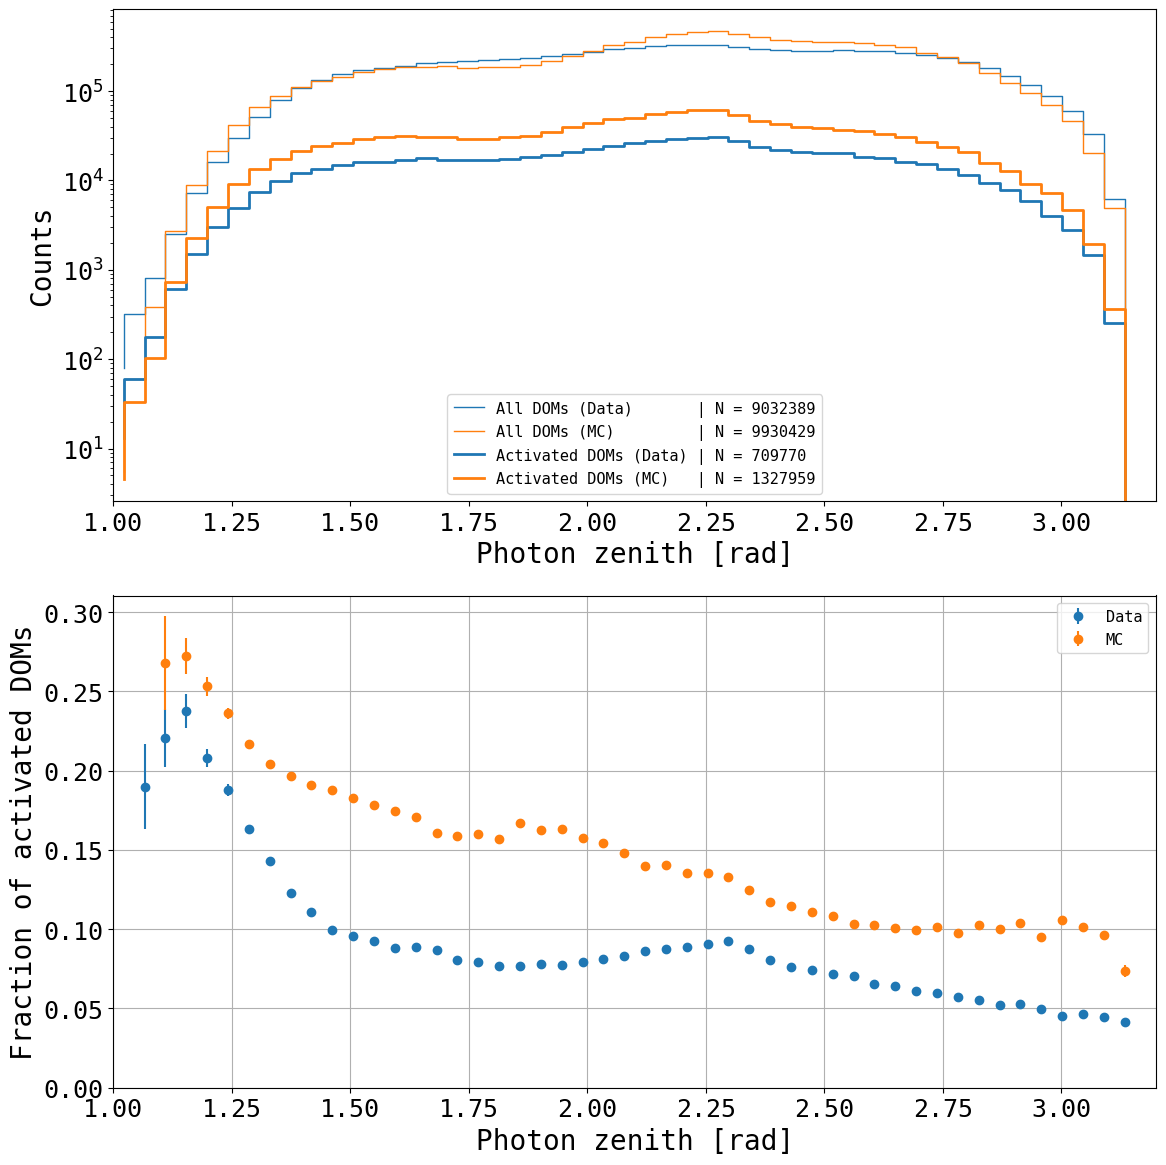

In [32]:
hs = {'bins':nbins, 'range':RANGE, 'histtype':'step', 'linewidth':2}
fig, ax = plt.subplots(2,1, figsize=(12,12))
where = 'pre'
ax[0].step(bin_centers, rd_all_doms,   where=where, linewidth=1, color='C00',   label='All DOMs (Data)       | N = {:.0f}'.format(np.sum(rd_all_doms)))
ax[0].step(bin_centers, mc_all_doms,   where=where, linewidth=1, color='C01',   label='All DOMs (MC)         | N = {:.0f}'.format(np.sum(mc_all_doms)))
#ax[0].step(bin_centers, mct_all_doms,  where=where, linewidth=1, color='black', label='All DOMs (Truth)      | N = {:.0f}'.format(np.sum(mct_all_doms)))

ax[0].step(bin_centers, rd_activated,  where=where, linewidth=2, color='C00',   label='Activated DOMs (Data) | N = {:.0f}'.format(np.sum(rd_activated)))
ax[0].step(bin_centers, mc_activated,  where=where, linewidth=2, color='C01',   label='Activated DOMs (MC)   | N = {:.0f}'.format(np.sum(mc_activated)))
#ax[0].step(bin_centers, mct_activated, where=where, linewidth=2, color='black', label='Activated DOMs (Truth)| N = {:.0f}'.format(np.sum(mct_activated)))

ax[0].legend(loc = 'best', fontsize = 11)
ax[0].set(xlabel = 'Photon zenith [rad]', ylabel = 'Counts', yscale='log', xlim=RANGE)
#ax[0].grid()
nmin = 50
ax[1].errorbar(bin_centers[rd_activated>=nmin], rdeff[rd_activated>=nmin], yerr=rdeff_err[rd_activated>=nmin],  color='C00',  fmt='o', label='Data')
ax[1].errorbar(bin_centers[mc_activated>=nmin], mceff[mc_activated>=nmin], yerr=mceff_err[mc_activated>=nmin],  color='C01',  fmt='o', label='MC')
#ax[1].errorbar(bin_centers[mct_activated>=nmin], mcteff[mct_activated>=nmin], yerr=mcteff_err[mct_activated>=nmin],color='black', fmt='o', label='Truth')

x1 = np.linspace(RANGE[0], RANGE[1], nbins)
#ax[1].set_ylim(bottom=0)
ax[1].set(xlabel = 'Photon zenith [rad]', ylabel = 'Fraction of activated DOMs', xlim=RANGE)
ax[1].set_ylim(bottom=0)
ax[1].legend(fontsize=11)
ax[1].grid()
plt.tight_layout()
plt.savefig('plots/zenith_efficiency.pdf')
plt.show()

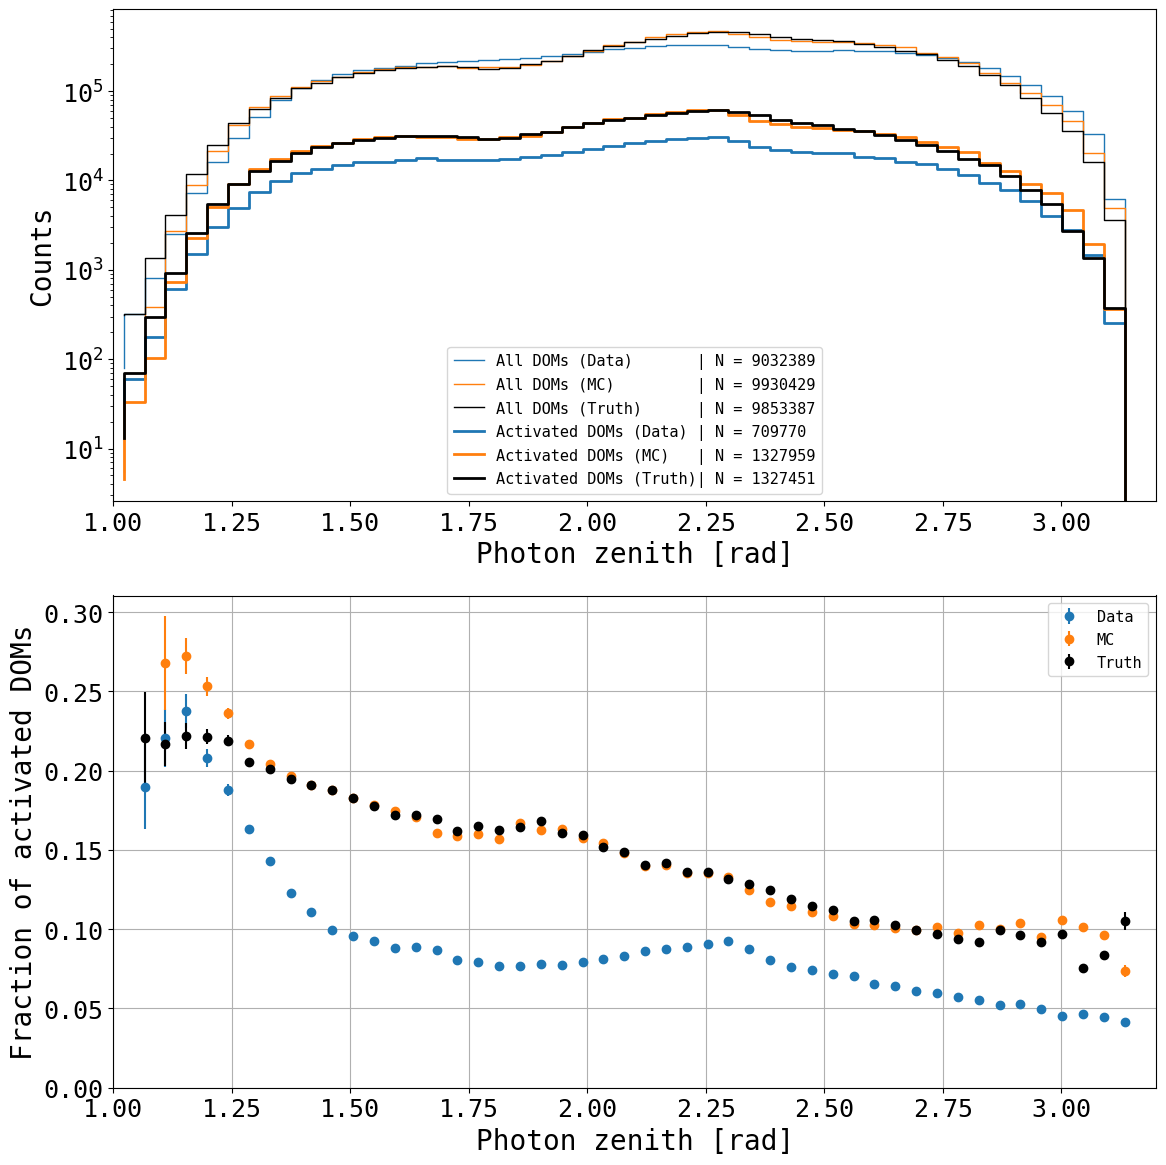

In [33]:
hs = {'bins':nbins, 'range':RANGE, 'histtype':'step', 'linewidth':2}
fig, ax = plt.subplots(2,1, figsize=(12,12))
where = 'pre'
ax[0].step(bin_centers, rd_all_doms,   where=where, linewidth=1, color='C00',   label='All DOMs (Data)       | N = {:.0f}'.format(np.sum(rd_all_doms)))
ax[0].step(bin_centers, mc_all_doms,   where=where, linewidth=1, color='C01',   label='All DOMs (MC)         | N = {:.0f}'.format(np.sum(mc_all_doms)))
ax[0].step(bin_centers, mct_all_doms,  where=where, linewidth=1, color='black', label='All DOMs (Truth)      | N = {:.0f}'.format(np.sum(mct_all_doms)))

ax[0].step(bin_centers, rd_activated,  where=where, linewidth=2, color='C00',   label='Activated DOMs (Data) | N = {:.0f}'.format(np.sum(rd_activated)))
ax[0].step(bin_centers, mc_activated,  where=where, linewidth=2, color='C01',   label='Activated DOMs (MC)   | N = {:.0f}'.format(np.sum(mc_activated)))
ax[0].step(bin_centers, mct_activated, where=where, linewidth=2, color='black', label='Activated DOMs (Truth)| N = {:.0f}'.format(np.sum(mct_activated)))

ax[0].legend(loc = 'best', fontsize = 11)
ax[0].set(xlabel = 'Photon zenith [rad]', ylabel = 'Counts', yscale='log', xlim=RANGE)
#ax[0].grid()
nmin = 50
ax[1].errorbar(bin_centers[rd_activated>=nmin], rdeff[rd_activated>=nmin], yerr=rdeff_err[rd_activated>=nmin],  color='C00',  fmt='o', label='Data')
ax[1].errorbar(bin_centers[mc_activated>=nmin], mceff[mc_activated>=nmin], yerr=mceff_err[mc_activated>=nmin],  color='C01',  fmt='o', label='MC')
ax[1].errorbar(bin_centers[mct_activated>=nmin], mcteff[mct_activated>=nmin], yerr=mcteff_err[mct_activated>=nmin],color='black', fmt='o', label='Truth')

x1 = np.linspace(RANGE[0], RANGE[1], nbins)
#ax[1].set_ylim(bottom=0)
ax[1].set(xlabel = 'Photon zenith [rad]', ylabel = 'Fraction of activated DOMs', xlim=RANGE)
ax[1].set_ylim(bottom=0)
ax[1].legend(fontsize=11)
ax[1].grid()

plt.tight_layout()
#plt.savefig('plots/zenith_efficiency_vs_truth.pdf')
plt.show()

# Without charge cosine version

In [34]:
hs = {'bins':nbins, 'range':RANGE, 'histtype':'step', 'linewidth':2}
fig, ax = plt.subplots(2,1, figsize=(12,12))
where = 'pre'
ax[0].step(np.cos(bin_centers), rd_all_doms,   where=where, linewidth=1, color='C00',   label='All DOMs (Data)       | N = {:.0f}'.format(np.sum(rd_all_doms)))
ax[0].step(np.cos(bin_centers), mc_all_doms,   where=where, linewidth=1, color='C01',   label='All DOMs (MC)         | N = {:.0f}'.format(np.sum(mc_all_doms)))
#ax[0].step(np.cos(bin_centers), mct_all_doms,  where=where, linewidth=1, color='black', label='All DOMs (Truth)      | N = {:.0f}'.format(np.sum(mct_all_doms)))
ax[0].step(np.cos(bin_centers), rd_activated,  where=where, linewidth=2, color='C00',   label='Activated DOMs (Data) | N = {:.0f}'.format(np.sum(rd_activated)))
ax[0].step(np.cos(bin_centers), mc_activated,  where=where, linewidth=2, color='C01',   label='Activated DOMs (MC)   | N = {:.0f}'.format(np.sum(mc_activated)))
#ax[0].step(np.cos(bin_centers), mct_activated, where=where, linewidth=2, color='black', label='Activated DOMs (Truth)| N = {:.0f}'.format(np.sum(mct_activated)))

ax[0].legend(loc = 'best', fontsize = 11)
ax[0].set(xlabel = 'cos(photon zenith)', ylabel = 'Counts', yscale='log')
#ax[0].grid()
nmin = 50
ax[1].errorbar(np.cos(bin_centers[rd_activated>=nmin]), rdeff[rd_activated>=nmin], yerr=rdeff_err[rd_activated>=nmin],  color='C00',  fmt='o', label='Data')
ax[1].errorbar(np.cos(bin_centers[mc_activated>=nmin]), mceff[mc_activated>=nmin], yerr=mceff_err[mc_activated>=nmin],  color='C01',  fmt='o', label='MC')
#ax[1].errorbar(np.cos(bin_centers[mct_activated>=nmin]), mcteff[mct_activated>=nmin], yerr=mcteff_err[mct_activated>=nmin],color='black', fmt='o', label='Truth')

x1 = np.linspace(RANGE[0], RANGE[1], nbins)
#ax[1].set_ylim(bottom=0)
ax[1].set(xlabel = 'cos(photon zenith)', ylabel = 'Fraction of activated DOMs')
ax[1].set_ylim(bottom=0)
ax[1].legend(fontsize=11)
ax[1].grid()
ax[]
plt.tight_layout()
#plt.savefig('plots/zenith_cos_efficiency.pdf')
plt.show()

SyntaxError: invalid syntax (2233394221.py, line 25)

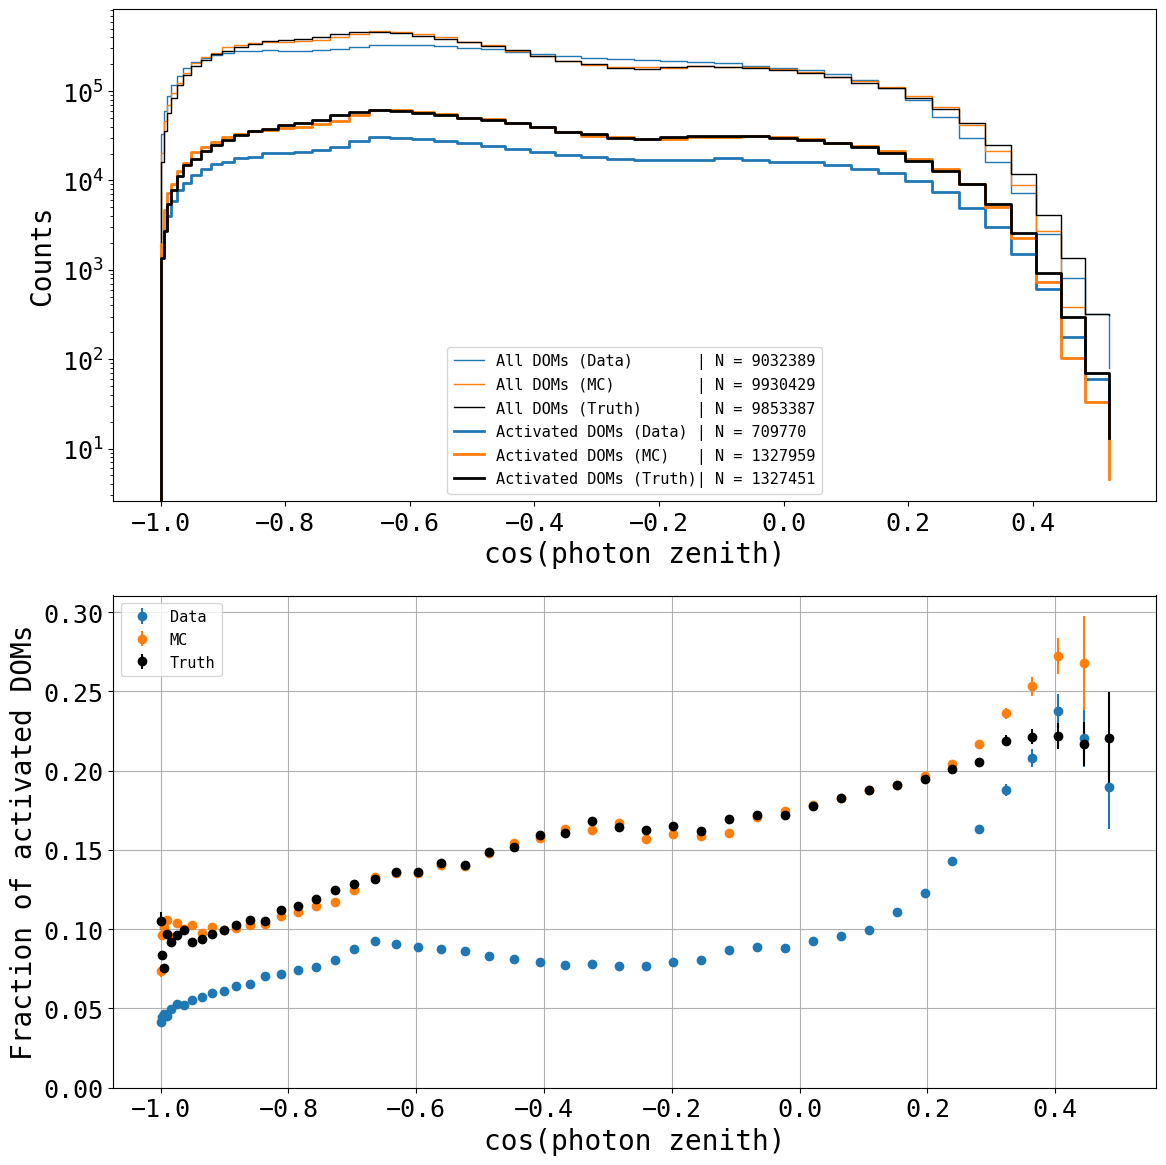

In [35]:
hs = {'bins':nbins, 'range':RANGE, 'histtype':'step', 'linewidth':2}
fig, ax = plt.subplots(2,1, figsize=(12,12))
where = 'pre'
ax[0].step(np.cos(bin_centers), rd_all_doms,   where=where, linewidth=1, color='C00',   label='All DOMs (Data)       | N = {:.0f}'.format(np.sum(rd_all_doms)))
ax[0].step(np.cos(bin_centers), mc_all_doms,   where=where, linewidth=1, color='C01',   label='All DOMs (MC)         | N = {:.0f}'.format(np.sum(mc_all_doms)))
ax[0].step(np.cos(bin_centers), mct_all_doms,  where=where, linewidth=1, color='black', label='All DOMs (Truth)      | N = {:.0f}'.format(np.sum(mct_all_doms)))
ax[0].step(np.cos(bin_centers), rd_activated,  where=where, linewidth=2, color='C00',   label='Activated DOMs (Data) | N = {:.0f}'.format(np.sum(rd_activated)))
ax[0].step(np.cos(bin_centers), mc_activated,  where=where, linewidth=2, color='C01',   label='Activated DOMs (MC)   | N = {:.0f}'.format(np.sum(mc_activated)))
ax[0].step(np.cos(bin_centers), mct_activated, where=where, linewidth=2, color='black', label='Activated DOMs (Truth)| N = {:.0f}'.format(np.sum(mct_activated)))

ax[0].legend(loc = 'best', fontsize = 11)
ax[0].set(xlabel = 'cos(photon zenith)', ylabel = 'Counts', yscale='log')
#ax[0].grid()
nmin = 50
ax[1].errorbar(np.cos(bin_centers[rd_activated>=nmin]), rdeff[rd_activated>=nmin], yerr=rdeff_err[rd_activated>=nmin],  color='C00',  fmt='o', label='Data')
ax[1].errorbar(np.cos(bin_centers[mc_activated>=nmin]), mceff[mc_activated>=nmin], yerr=mceff_err[mc_activated>=nmin],  color='C01',  fmt='o', label='MC')
ax[1].errorbar(np.cos(bin_centers[mct_activated>=nmin]), mcteff[mct_activated>=nmin], yerr=mcteff_err[mct_activated>=nmin],color='black', fmt='o', label='Truth')

x1 = np.linspace(RANGE[0], RANGE[1], nbins)
#ax[1].set_ylim(bottom=0)
ax[1].set(xlabel = 'cos(photon zenith)', ylabel = 'Fraction of activated DOMs')
ax[1].set_ylim(bottom=0)
ax[1].legend(fontsize=11)
ax[1].grid()
plt.tight_layout()
#plt.savefig('plots/zenith_cos_efficiency_vs_truth.pdf')
plt.show()

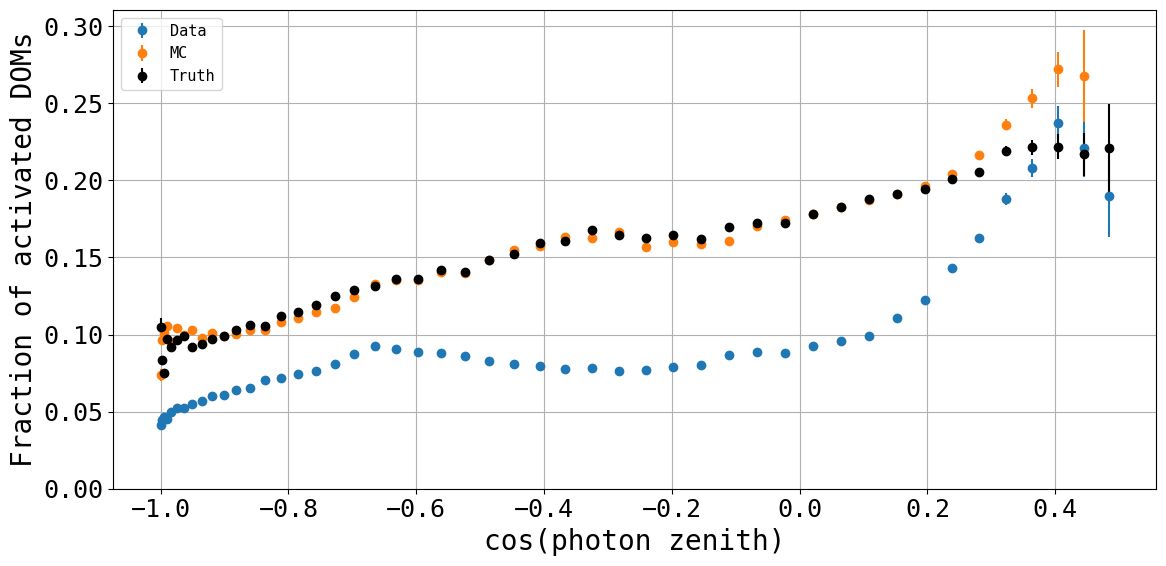

In [36]:
hs = {'bins':nbins, 'range':RANGE, 'histtype':'step', 'linewidth':2}
fig, ax = plt.subplots(1, figsize=(12,6))
where = 'pre'
nmin = 50
ax.errorbar(np.cos(bin_centers[rd_activated>=nmin]), rdeff[rd_activated>=nmin], yerr=rdeff_err[rd_activated>=nmin],  color='C00',  fmt='o', label='Data')
ax.errorbar(np.cos(bin_centers[mc_activated>=nmin]), mceff[mc_activated>=nmin], yerr=mceff_err[mc_activated>=nmin],  color='C01',  fmt='o', label='MC')
ax.errorbar(np.cos(bin_centers[mct_activated>=nmin]), mcteff[mct_activated>=nmin], yerr=mcteff_err[mct_activated>=nmin],color='black', fmt='o', label='Truth')

x1 = np.linspace(RANGE[0], RANGE[1], nbins)
#ax[1].set_ylim(bottom=0)
ax.set(xlabel = 'cos(photon zenith)', ylabel = 'Fraction of activated DOMs')
ax.set_ylim(bottom=0)
ax.legend(fontsize=11)
ax.grid()
plt.tight_layout()
#plt.savefig('plots/zenith_cos_efficiency_ratio.pdf')
plt.show()

In [37]:
np.arccos(.4)

1.1592794807274085

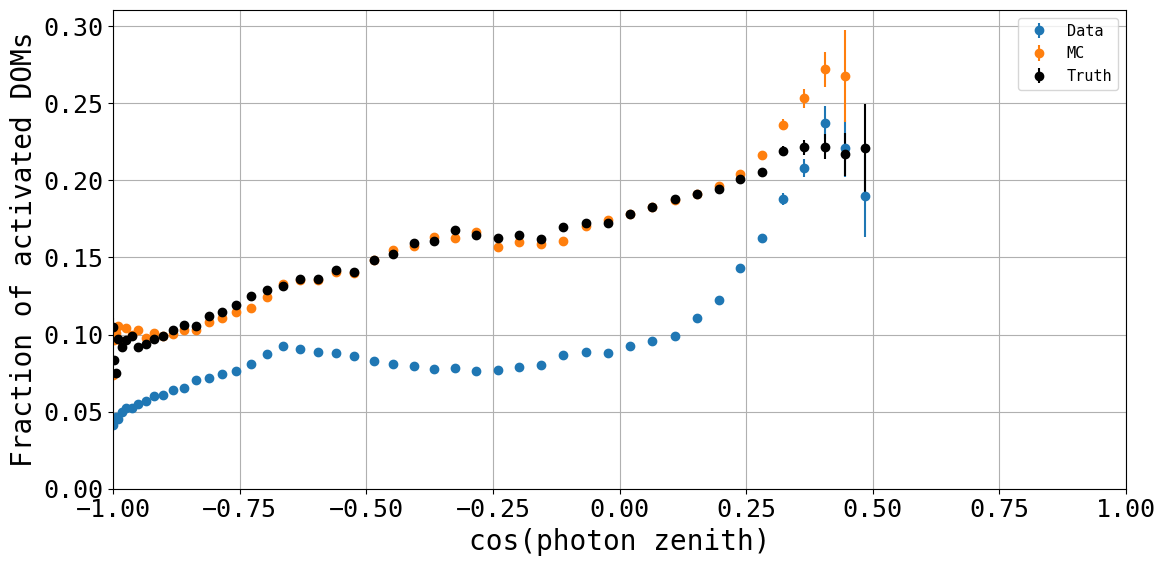

In [38]:
hs = {'bins':nbins, 'range':RANGE, 'histtype':'step', 'linewidth':2}
fig, ax = plt.subplots(1, figsize=(12,6))
where = 'pre'
nmin = 50
ax.errorbar(np.cos(bin_centers[rd_activated>=nmin]), rdeff[rd_activated>=nmin], yerr=rdeff_err[rd_activated>=nmin],  color='C00',  fmt='o', label='Data')
ax.errorbar(np.cos(bin_centers[mc_activated>=nmin]), mceff[mc_activated>=nmin], yerr=mceff_err[mc_activated>=nmin],  color='C01',  fmt='o', label='MC')
ax.errorbar(np.cos(bin_centers[mct_activated>=nmin]), mcteff[mct_activated>=nmin], yerr=mcteff_err[mct_activated>=nmin],color='black', fmt='o', label='Truth')

x1 = np.linspace(RANGE[0], RANGE[1], nbins)
#ax[1].set_ylim(bottom=0)
ax.set(xlabel = 'cos(photon zenith)', ylabel = 'Fraction of activated DOMs')
ax.set_ylim(bottom=0)
ax.set_xlim(-1,1)
ax.legend(fontsize=11)
ax.grid()
plt.tight_layout()
#plt.savefig('plots/zenith_cos_efficiency_ratio.pdf')
plt.show()

# With Charge

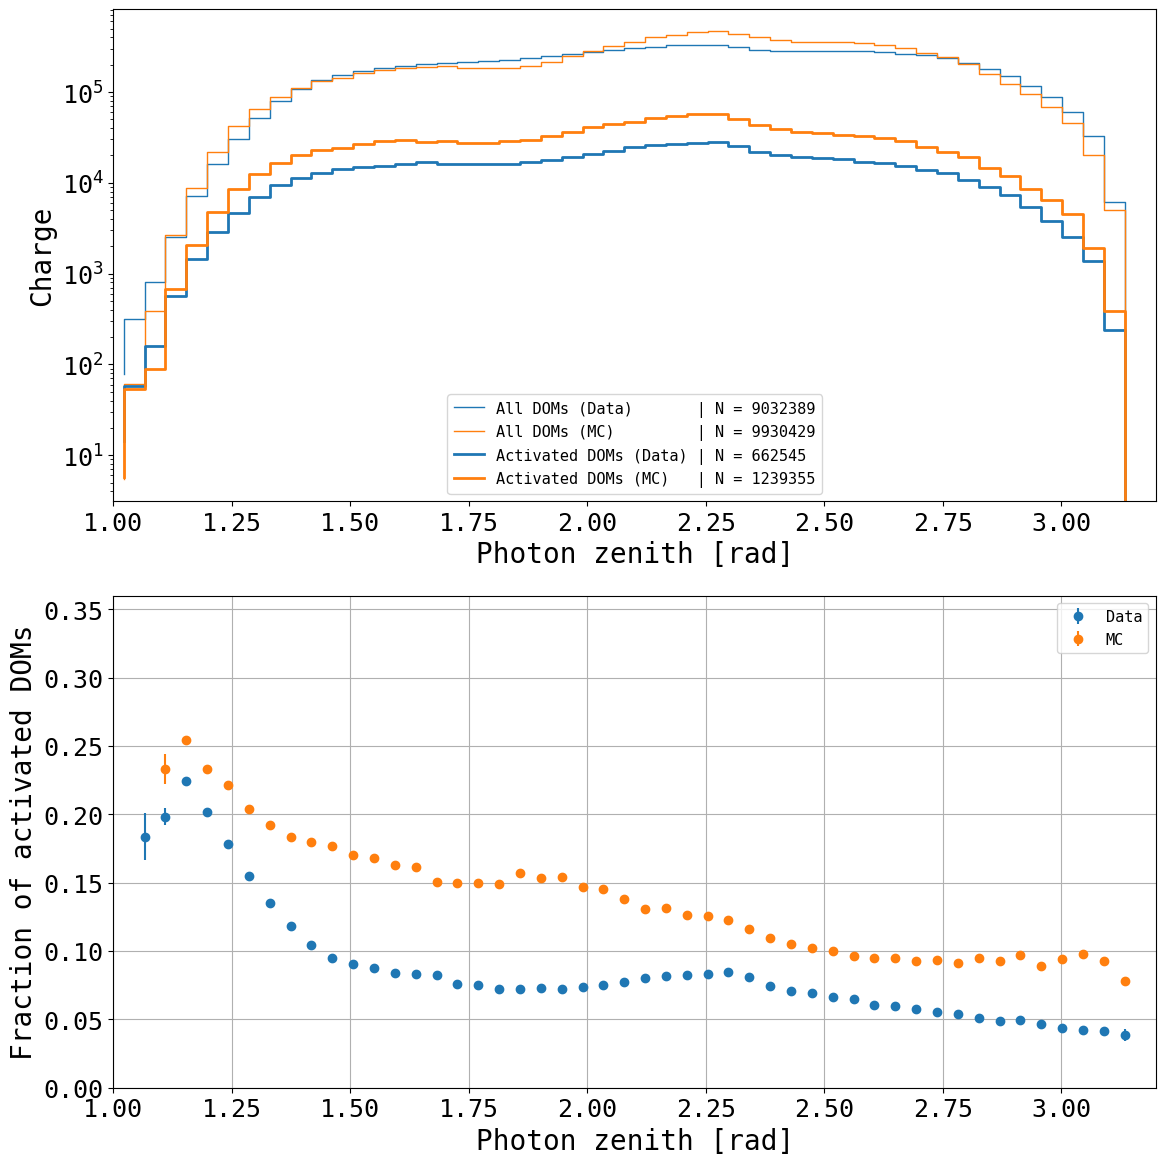

In [ ]:
hs = {'bins':nbins, 'range':RANGE, 'histtype':'step', 'linewidth':2}
fig, ax = plt.subplots(2,1, figsize=(12,12))
where = 'pre'
ax[0].step(bin_centers, rd_all_doms,   where=where, linewidth=1, color='C00',   label='All DOMs (Data)       | N = {:.0f}'.format(np.sum(rd_all_doms)))
ax[0].step(bin_centers, mc_all_doms,   where=where, linewidth=1, color='C01',   label='All DOMs (MC)         | N = {:.0f}'.format(np.sum(mc_all_doms)))
#ax[0].step(bin_centers, mct_all_doms,  where=where, linewidth=1, color='black', label='All DOMs (Truth)      | N = {:.0f}'.format(np.sum(mct_all_doms)))

ax[0].step(bin_centers, qrd_activated,  where=where, linewidth=2, color='C00',   label='Activated DOMs (Data) | N = {:.0f}'.format(np.sum(qrd_activated)))
ax[0].step(bin_centers, qmc_activated,  where=where, linewidth=2, color='C01',   label='Activated DOMs (MC)   | N = {:.0f}'.format(np.sum(qmc_activated)))
#ax[0].step(bin_centers, qmct_activated, where=where, linewidth=2, color='black', label='Activated DOMs (Truth)| N = {:.0f}'.format(np.sum(qmct_activated)))

ax[0].legend(loc = 'best', fontsize = 11)
ax[0].set(xlabel = 'Photon zenith [rad]', ylabel = 'Charge', yscale='log', xlim=RANGE)
#ax[0].grid()
nmin = 50
ax[1].errorbar(bin_centers[qrd_activated>=nmin], qrdeff[qrd_activated>=nmin], yerr=qrdeff_err[qrd_activated>=nmin],  color='C00',  fmt='o', label='Data')
ax[1].errorbar(bin_centers[qmc_activated>=nmin], qmceff[qmc_activated>=nmin], yerr=qmceff_err[qmc_activated>=nmin],  color='C01',  fmt='o', label='MC')
#ax[1].errorbar(bin_centers[qmct_activated>=nmin], qmcteff[qmct_activated>=nmin], yerr=qmcteff_err[qmct_activated>=nmin],color='black', fmt='o', label='Truth')

x1 = np.linspace(RANGE[0], RANGE[1], nbins)
#ax[1].set_ylim(bottom=0)
ax[1].set(xlabel = 'Photon zenith [rad]', ylabel = 'Fraction of activated DOMs', xlim=RANGE, ylim=(0,0.36))
ax[1].legend(fontsize=11)
ax[1].grid()
plt.tight_layout()
plt.savefig('plots/zenith_charge_efficiency.pdf')
plt.show()

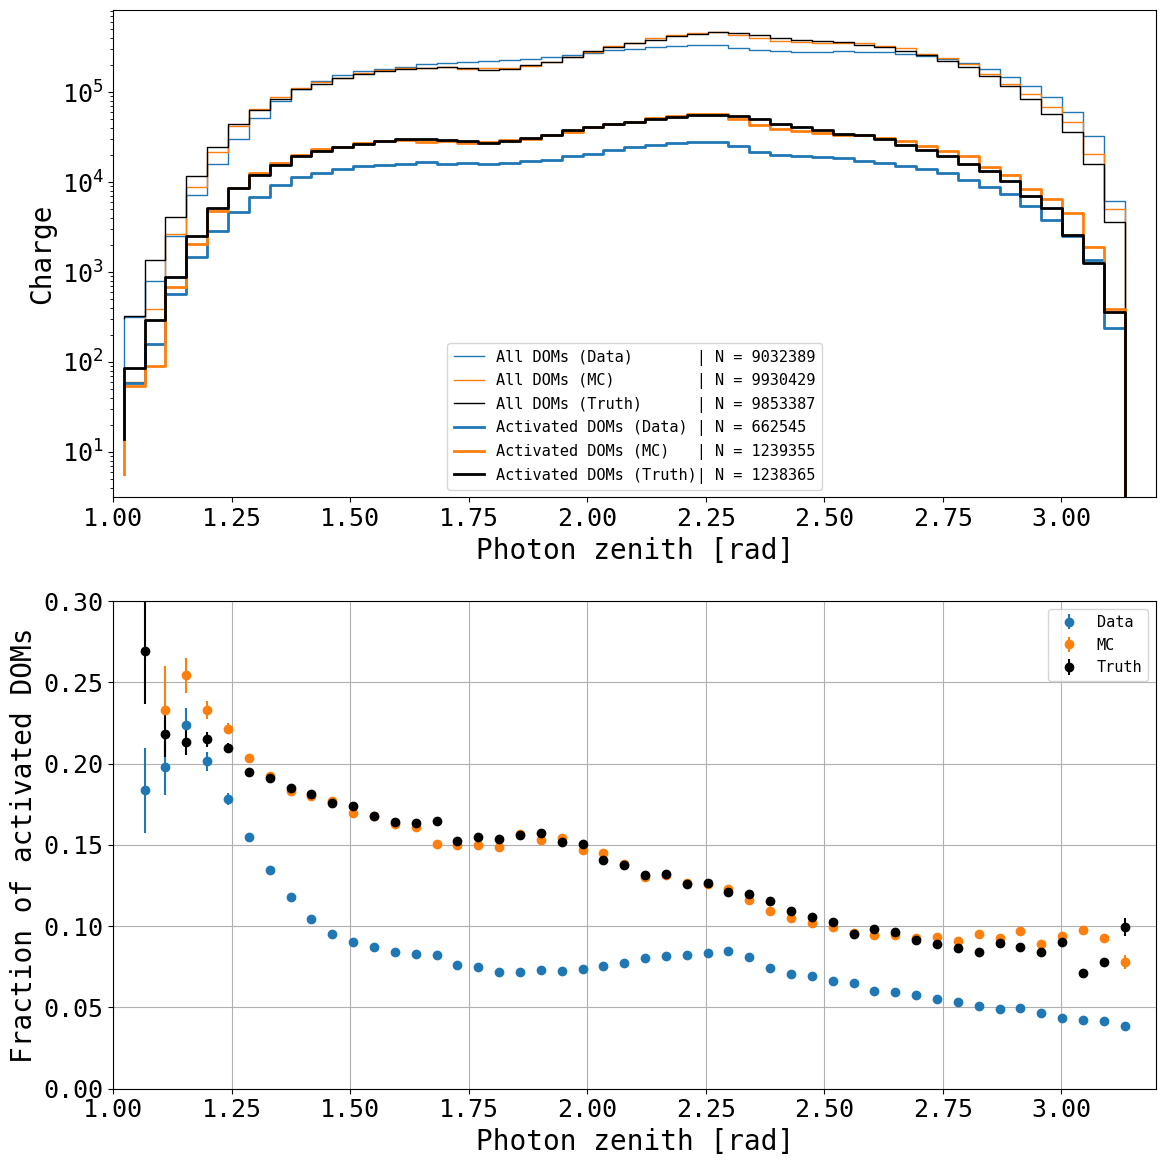

In [14]:
hs = {'bins':nbins, 'range':RANGE, 'histtype':'step', 'linewidth':2}
fig, ax = plt.subplots(2,1, figsize=(12,12))
where = 'pre'
ax[0].step(bin_centers, rd_all_doms,   where=where, linewidth=1, color='C00',   label='All DOMs (Data)       | N = {:.0f}'.format(np.sum(rd_all_doms)))
ax[0].step(bin_centers, mc_all_doms,   where=where, linewidth=1, color='C01',   label='All DOMs (MC)         | N = {:.0f}'.format(np.sum(mc_all_doms)))
ax[0].step(bin_centers, mct_all_doms,  where=where, linewidth=1, color='black', label='All DOMs (Truth)      | N = {:.0f}'.format(np.sum(mct_all_doms)))

ax[0].step(bin_centers, qrd_activated,  where=where, linewidth=2, color='C00',   label='Activated DOMs (Data) | N = {:.0f}'.format(np.sum(qrd_activated)))
ax[0].step(bin_centers, qmc_activated,  where=where, linewidth=2, color='C01',   label='Activated DOMs (MC)   | N = {:.0f}'.format(np.sum(qmc_activated)))
ax[0].step(bin_centers, qmct_activated, where=where, linewidth=2, color='black', label='Activated DOMs (Truth)| N = {:.0f}'.format(np.sum(qmct_activated)))

ax[0].legend(loc = 'best', fontsize = 11)
ax[0].set(xlabel = 'Photon zenith [rad]', ylabel = 'Charge', yscale='log', xlim=RANGE)
#ax[0].grid()
nmin = 50
ax[1].errorbar(bin_centers[qrd_activated>=nmin], qrdeff[qrd_activated>=nmin], yerr=qrdeff_err[qrd_activated>=nmin],  color='C00',  fmt='o', label='Data')
ax[1].errorbar(bin_centers[qmc_activated>=nmin], qmceff[qmc_activated>=nmin], yerr=qmceff_err[qmc_activated>=nmin],  color='C01',  fmt='o', label='MC')
ax[1].errorbar(bin_centers[qmct_activated>=nmin], qmcteff[qmct_activated>=nmin], yerr=qmcteff_err[qmct_activated>=nmin],color='black', fmt='o', label='Truth')

x1 = np.linspace(RANGE[0], RANGE[1], nbins)
#ax[1].set_ylim(bottom=0)
ax[1].set(xlabel = 'Photon zenith [rad]', ylabel = 'Fraction of activated DOMs', xlim=RANGE, ylim=(0,0.3))
ax[1].set_ylim(bottom=0)

ax[1].legend(fontsize=11)
ax[1].grid()
plt.tight_layout()
#plt.savefig('plots/zenith_charge_efficiency_vs_truth.pdf')
plt.show()

# With charge cosine version

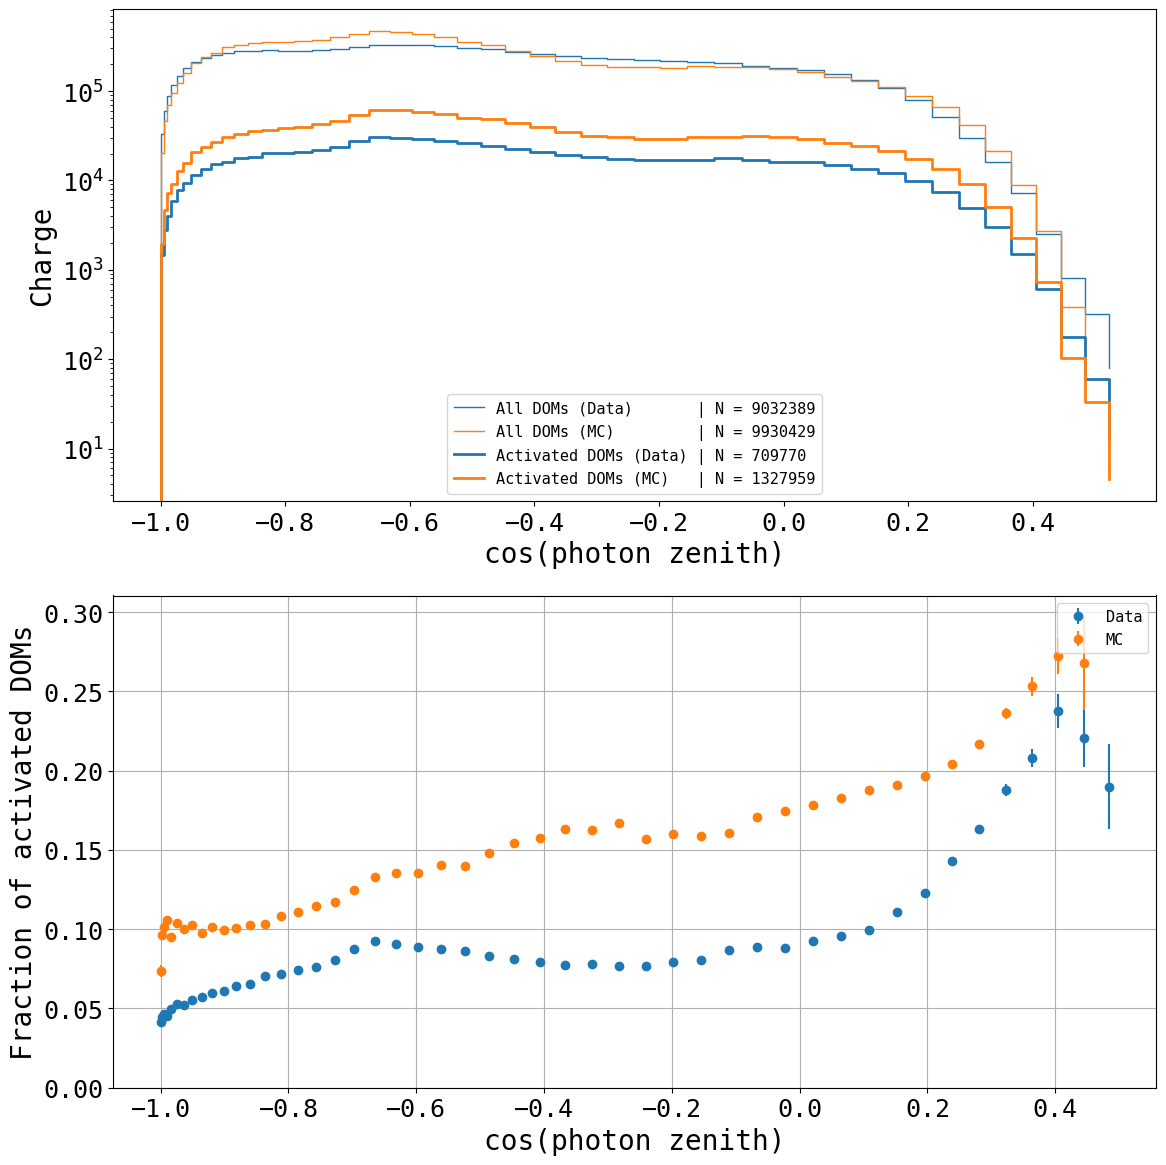

In [17]:
hs = {'bins':nbins, 'range':RANGE, 'histtype':'step', 'linewidth':2}
fig, ax = plt.subplots(2,1, figsize=(12,12))
where = 'pre'
ax[0].step(np.cos(bin_centers), rd_all_doms,   where=where, linewidth=1, color='C00',   label='All DOMs (Data)       | N = {:.0f}'.format(np.sum(rd_all_doms)))
ax[0].step(np.cos(bin_centers), mc_all_doms,   where=where, linewidth=1, color='C01',   label='All DOMs (MC)         | N = {:.0f}'.format(np.sum(mc_all_doms)))
#ax[0].step(np.cos(bin_centers), mct_all_doms,  where=where, linewidth=1, color='black', label='All DOMs (Truth)      | N = {:.0f}'.format(np.sum(mct_all_doms)))
ax[0].step(np.cos(bin_centers), rd_activated,  where=where, linewidth=2, color='C00',   label='Activated DOMs (Data) | N = {:.0f}'.format(np.sum(rd_activated)))
ax[0].step(np.cos(bin_centers), mc_activated,  where=where, linewidth=2, color='C01',   label='Activated DOMs (MC)   | N = {:.0f}'.format(np.sum(mc_activated)))
#ax[0].step(np.cos(bin_centers), mct_activated, where=where, linewidth=2, color='black', label='Activated DOMs (Truth)| N = {:.0f}'.format(np.sum(mct_activated)))

ax[0].legend(loc = 'best', fontsize = 11)
ax[0].set(xlabel = 'cos(photon zenith)', ylabel = 'Charge', yscale='log')
#ax[0].grid()
nmin = 50
ax[1].errorbar(np.cos(bin_centers[rd_activated>=nmin]), rdeff[rd_activated>=nmin], yerr=rdeff_err[rd_activated>=nmin],  color='C00',  fmt='o', label='Data')
ax[1].errorbar(np.cos(bin_centers[mc_activated>=nmin]), mceff[mc_activated>=nmin], yerr=mceff_err[mc_activated>=nmin],  color='C01',  fmt='o', label='MC')
#ax[1].errorbar(np.cos(bin_centers[mct_activated>=nmin]), mcteff[mct_activated>=nmin], yerr=mcteff_err[mct_activated>=nmin],color='black', fmt='o', label='Truth')

x1 = np.linspace(RANGE[0], RANGE[1], nbins)
#ax[1].set_ylim(bottom=0)
ax[1].set(xlabel = 'cos(photon zenith)', ylabel = 'Fraction of activated DOMs')
ax[1].set_ylim(bottom=0)
ax[1].legend(fontsize=11)
ax[1].grid()
plt.tight_layout()
#plt.savefig('plots/zenith_cos_efficiency.pdf')
plt.show()

# The only plot that makes it into my thesis below

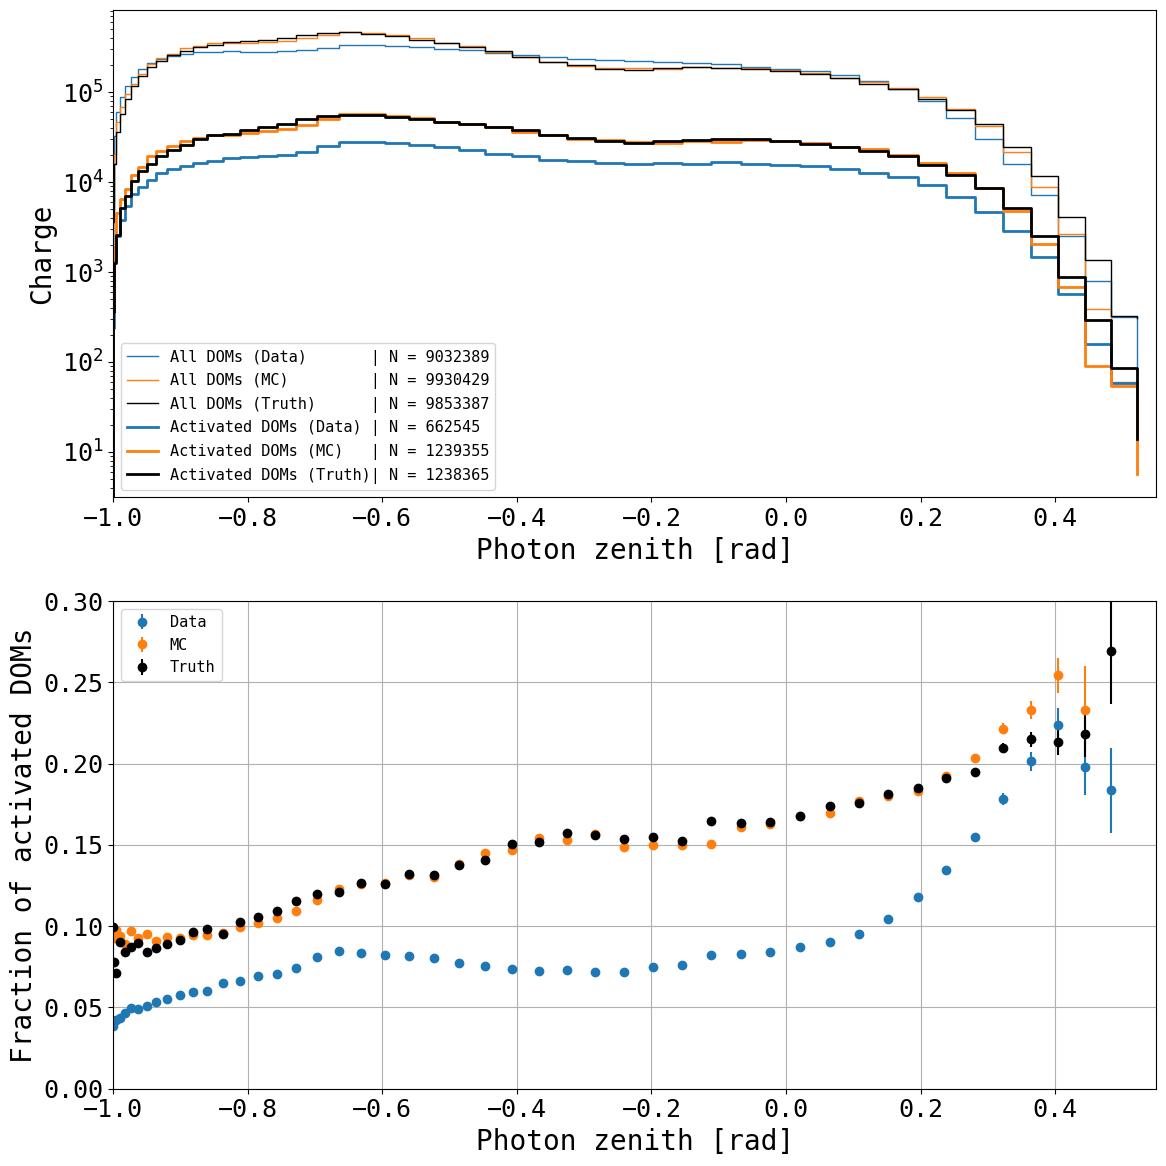

In [29]:
cosrange1 = (-1,0.55)
hs = {'bins':nbins, 'range':cosrange1, 'histtype':'step', 'linewidth':2}
fig, ax = plt.subplots(2,1, figsize=(12,12))
where = 'pre'
ax[0].step(np.cos(bin_centers), rd_all_doms,   where=where, linewidth=1, color='C00',   label='All DOMs (Data)       | N = {:.0f}'.format(np.sum(rd_all_doms)))
ax[0].step(np.cos(bin_centers), mc_all_doms,   where=where, linewidth=1, color='C01',   label='All DOMs (MC)         | N = {:.0f}'.format(np.sum(mc_all_doms)))
ax[0].step(np.cos(bin_centers), mct_all_doms,  where=where, linewidth=1, color='black', label='All DOMs (Truth)      | N = {:.0f}'.format(np.sum(mct_all_doms)))
ax[0].step(np.cos(bin_centers), qrd_activated,  where=where, linewidth=2, color='C00',   label='Activated DOMs (Data) | N = {:.0f}'.format(np.sum(qrd_activated)))
ax[0].step(np.cos(bin_centers), qmc_activated,  where=where, linewidth=2, color='C01',   label='Activated DOMs (MC)   | N = {:.0f}'.format(np.sum(qmc_activated)))
ax[0].step(np.cos(bin_centers), qmct_activated, where=where, linewidth=2, color='black', label='Activated DOMs (Truth)| N = {:.0f}'.format(np.sum(qmct_activated)))

ax[0].legend(loc = 'best', fontsize = 11)
ax[0].set(xlabel = 'Photon zenith [rad]', ylabel = 'Charge', yscale='log', xlim=cosrange1)
#ax[0].grid()
nmin = 50
ax[1].errorbar(np.cos(bin_centers[qrd_activated>=nmin]), qrdeff[qrd_activated>=nmin], yerr=qrdeff_err[qrd_activated>=nmin],  color='C00',  fmt='o', label='Data')
ax[1].errorbar(np.cos(bin_centers[qmc_activated>=nmin]), qmceff[qmc_activated>=nmin], yerr=qmceff_err[qmc_activated>=nmin],  color='C01',  fmt='o', label='MC')
ax[1].errorbar(np.cos(bin_centers[qmct_activated>=nmin]), qmcteff[qmct_activated>=nmin], yerr=qmcteff_err[qmct_activated>=nmin],color='black', fmt='o', label='Truth')

x1 = np.linspace(RANGE[0], RANGE[1], nbins)
#ax[1].set_ylim(bottom=0)
ax[1].set(xlabel = 'Photon zenith [rad]', ylabel = 'Fraction of activated DOMs', ylim=(0,0.3), xlim=cosrange1)
#ax[1].set_ylim(bottom=0)
#ax[1].set_ylim(bottom=0)
ax[1].legend(fontsize=11)
ax[1].grid()
plt.tight_layout()
plt.savefig('plots/zenith_cos_charge_efficiency_vs_truth.pdf')
plt.show()